
# Criação de Representações Visuais e Estética

Prof. Gustavo Oliveira

CI/DCC/UFPB

[gcpeixoto.github.com/DATAVIZ](gcpeixoto.github.com/DATAVIZ)

## Modelo referencial

- Componentes do modelo para geração de RVs:
    - _Entrada_: dado bruto manipulável
    - _Pré-Processamento_: preparação e tratamento dos dados.
    - _Mapeamento_: projeto gráfico, estruturas visuais e _estética_.
    - _Visualização_: produto final, a própria RV.
    
Nota: mapeamento de valores em formas quantificadas determinarão a estética.


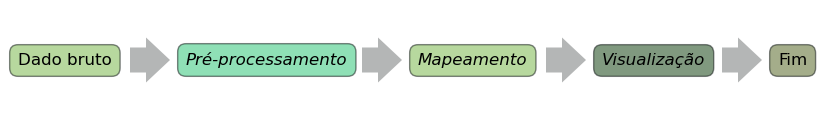

In [1]:
# RV produzida por código (ver site do curso)
import aux03a

### Dado bruto

- Toda sorte de dado disponível não tratado
- Raramente possuem estrutura lógica de fácil compreensão 
- Quando minimamente organizados, melhor manipuláveis por:
    - tabelas;
    - serializações;
    - outro formato apropriado para _datasets_;

#### Exemplo 1: registros cirúrgicos e obstétricos de um hospital

- Números de cirurgias \(C\) e partos \(P\) realizados nos blocos 1 (BLC1), 2 (BLC2) e 3 (BLC3) de um hospital público de grande porte no primeiro semestre de 2021 que levaram até 2 horas (I) ou mais do que 2 horas (II) de intervenção.

```
-- raw-data-hospital.txt
:BLC1 01/Fev/2021 I 30C 2P
:BLC2 20/Fev/2021 II 0C 3P
:BLC1 02/Mar/2021 I 0C 1P
:BLC3 03/Mar/2021 II 0C 0P
:BLC1 22/Abr/2021 I 7C 2P
:BLC1 21-Abr/2021 II 1C 0p
:BLC2 12-Mai/2021 I 22C 10P
:BLC3 22-Mai/2021 II 1C 5P
:BLC3 11/06/2021 I 36C 1P
:blc2 01/06/2021 II 11C 22P
.blc1 12.Jun.2021 I 33c 20P
.blc2 30.Jun.2021 II 0C 17P
.blc1 15.Jun.2021 I 42c 32P
```

#### Exemplo 2: monitoramento climático em tempo real

- Registros de temperatura coletados por sensores localizados em torres de captação de dois domínios ecoclimáticos terrestres dos EUA (03: Flórida e 10: Colorado)

<img src="../figs/NEONtower.png" width="700" height="700">


Fonte: [National Ecolological Observatory Network](https://www.neonscience.org/resources/learning-hub/tutorials/explore-data-hdfview).

In [3]:
import h5py as h5
file_hdf = h5.File('../data/NEONDSTowerTemperatureData.hdf5','r')
for i in range(5):
    print(file_hdf['Domain_03']['OSBS']['min_1']['boom_1']['temperature'][i])

(b'2014-04-01 00:00:00.0', 60, 15.06153847, 14.96886086, 15.15624697, 0.00265502, 0.00665209, 0.01620325)
(b'2014-04-01 00:01:00.0', 60, 14.99857787, 14.93719665, 15.04274265, 0.00125412, 0.00457187, 0.01306111)
(b'2014-04-01 00:02:00.0', 60, 15.26231288, 15.03502109, 15.56682569, 0.04143754, 0.02627976, 0.05349682)
(b'2014-04-01 00:03:00.0', 60, 15.4535136, 15.3855348, 15.53449212, 0.00117476, 0.00442485, 0.01286833)
(b'2014-04-01 00:04:00.0', 60, 15.35306231, 15.23799073, 15.42345761, 0.00352644, 0.00766642, 0.01788372)


A tupla armazena: data e hora da medição, número de pontos de cálculo das estatísticas (60 segundos), temperaturas média, mínima e máxima (por minuto), variância, erro e incerteza.

##### Introspectando arquivos _HDF_

- Visualização da "árvore" possível via interface ou linha de comando. 
    - Caso 1: [HDF View](https://www.hdfgroup.org/downloads/hdfview/)
    - Caso 2: seguir o guia do usuário. Neste caso, há pelo menos dois modos práticos: 

- **Modo 1**: UDF para impressão dos objetos e atributos:

In [4]:
def print_h5_tree(name, obj):
    print(name, dict(obj.attrs))

file_hdf = h5.File('../data/NEONDSTowerTemperatureData.hdf5','r')
file_hdf.visititems(print_h5_tree)    

Domain_03 {}
Domain_03/OSBS {'LatLon': '29.68927/-81.99343', 'Site Name': 'Ordway-Swisher Biological Station Site'}
Domain_03/OSBS/min_1 {}
Domain_03/OSBS/min_1/boom_1 {'Sensor Height': '0.41 m', 'Sensor Type': 'Thermometrics Climate RTD 100  Omega  Probe and Met One 076B aspirated radiation shield'}
Domain_03/OSBS/min_1/boom_1/temperature {'Product ID': 'NEON.D03.CS1.DP1.00002.001.002.001.001', 'Product Name': '1 minute minimum temperature tower level 1', 'date': 'Date and time of the first measurement', 'max': 'The maximum temperature of numPts in Celcius, over a given time range', 'mean': 'The mean temperature of numPts in Celcius, calculated over a given time range', 'min': 'The minimum temperature of numPts in Celcius, over a given time range', 'numPts': 'The number of points used to calculate each summary measure', 'stdErr': 'The standard error of the mean temperature of numPts in Celcius, calculated over a given time range', 'uncertainty': 'The uncertainty of the mean temperatur

- **Modo 2**: usando o pacote `nexusformat` – instalável via `pip install nexusformat` —, que lida com o formato [NeXus](https://www.nexusformat.org):

```python
# importação da função `nxload`
from nexusformat.nexus import nxload

# leitura do arquivo
hdf5 = nxload('../data/NEONDSTowerTemperatureData.hdf5')

# impressão
print(hdf5.tree)
```

### Pré-Processamento

- Podemos realizar o _workflow_ de ETL tradicional com `pandas` e outros módulos necessários
- Aplicar filtragens, _casting_, _splitting_ de strings, renomeação de atributos, salvamento em formatos tabelares etc. 

#### Exemplo 1: reorganizando o arquivo de registros cirúrgicos e obstétricos

In [7]:
import pandas as pd

df_h = pd.read_csv('../data/raw-data-hospital.txt',sep=' ',names=['Bloco','Data','Porte','Cirurgias','Partos'])

# remoção de inconsistências
df_h['Bloco'] = df_h['Bloco'].str.upper().str.strip(':BLC').str.strip('.BLC')
df_h['Data'] = df_h['Data'].str.replace('-','/').str.replace('.','/').\
                str.replace('/','-').str.replace('06','Jun').\
                str.replace(r'([A-Z][a-z][a-z])',lambda x: x.group().lower(),regex=True)
df_h['Cirurgias'] = df_h['Cirurgias'].str.strip('C').str.strip('c')
df_h['Partos'] = df_h['Partos'].str.strip('P').str.strip('p')

# reindexação
df_h.set_index('Data',inplace=True)

/var/folders/ll/g0vl8b194pbfyp4cwpzz4p740000gn/T/ipykernel_96488/1688322632.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_h['Data'] = df_h['Data'].str.replace('-','/').str.replace('.','/').\


In [8]:
df_h

,Bloco,Porte,Cirurgias,Partos
Data,,,,
01-fev-2021,1,I,30,2
20-fev-2021,2,II,0,3
02-mar-2021,1,I,0,1
03-mar-2021,3,II,0,0
22-abr-2021,1,I,7,2
21-abr-2021,1,II,1,0
12-mai-2021,2,I,22,10
22-mai-2021,3,II,1,5
11-jun-2021,3,I,36,1


Tarefa: corrija a ordem lexicográfica do index tornando as datas em objetos `datetime`.

#### Exemplo 2: acessando dados de temperatura

- Pdemos usar `keys` para acessar os _datasets_ e usar métodos do `numpy` e do `pandas` para recuperar a estrutura e criar os _dataframes_ diretamente.

In [9]:
from pandas import DataFrame
from numpy import array

df_t = DataFrame(array(file_hdf['Domain_10']['STER']['min_1']['boom_2']['temperature']))
df_t.set_index('date')

,numPts,mean,min,max,variance,stdErr,uncertainty
date,,,,,,,
b'2014-04-01 00:00:00.0',60,6.398707,6.347253,6.440027,0.001093,0.004269,0.012512
b'2014-04-01 00:01:00.0',60,6.375695,6.305179,6.439385,0.002014,0.005793,0.014728
b'2014-04-01 00:02:00.0',60,6.360941,6.293467,6.430070,0.002428,0.006361,0.015624
b'2014-04-01 00:03:00.0',60,6.384913,6.336319,6.418260,0.000289,0.002193,0.010185
b'2014-04-01 00:04:00.0',60,6.283479,6.236615,6.332181,0.000531,0.002975,0.010937
...,...,...,...,...,...,...,...
b'2014-04-03 23:56:00.0',60,6.495163,6.486047,6.513575,0.000053,0.000941,0.009399
b'2014-04-03 23:57:00.0',60,6.475617,6.460469,6.497839,0.000119,0.001411,0.009627
b'2014-04-03 23:58:00.0',60,6.464438,6.456761,6.471775,0.000020,0.000573,0.009280


### Mapeamento (Visual)

> Processo de transferir os dados para a área de visualização e exibi-los através de estruturas visuais adequadas. 

- Há muitos dados _abstratos_, cuja natureza não se vincula a uma estrutura topológica (forma) ou a uma localização geográfica. Nesses casos, a estrutura visual mais adequada pode não ser imediata. 

Exemplos: 

- Temperaturas coletadas do monitoramento ambiental são diretamente associadas com uma localização geográfica dentro do território americano. 
- Dados de registro hospitalar: locais são desconhecidos. Casos como este não possuem correspondência imediata com dimensões. 

#### Estruturas fundamentais do mapeamento visual

- _substrato espacial_: define as dimensões do espaço físico onde a representação visual é criada;
- _elementos gráficos_: caracterizam os elementos visuais que aparecem no espaço;
- _propriedades gráficas_: definem-se pelas propriedades dos elementos gráficos às quais o olho humano (retina) são sensíveis. São também conhecidos como _atributos visuais_.

### Substrato retilinear

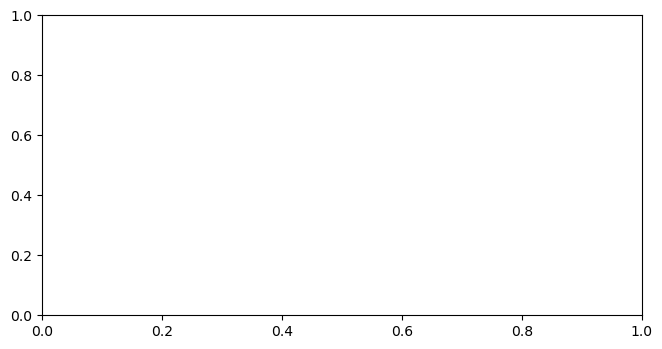

In [10]:
from matplotlib.pyplot import figure

fig = figure(figsize=(6,3));
fig.add_axes((0,0,1,1),projection='rectilinear');

### Substrato polar

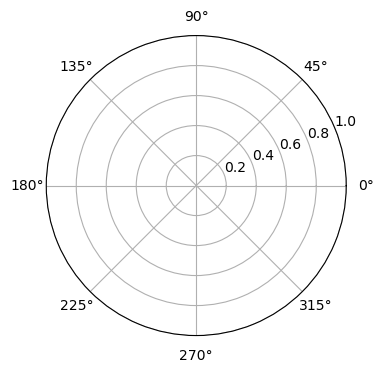

In [11]:
from matplotlib.pyplot import figure

fig = figure(figsize=(6,3));
fig.add_axes((0,0,1,1),projection='polar');

### Substrato 3D

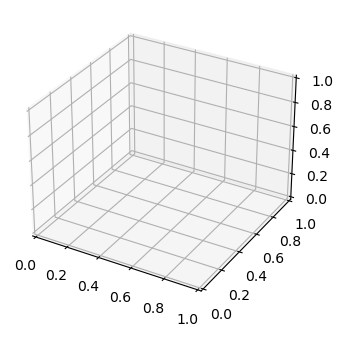

In [12]:
from matplotlib.pyplot import figure

fig = figure(figsize=(6,3));
fig.add_axes((0,0,1,1),projection='3d');

### Substrato Lambert

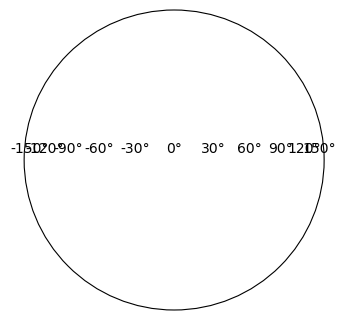

In [13]:
from matplotlib.pyplot import figure

fig = figure(figsize=(6,3));
fig.add_axes((0,0,1,1),projection='lambert');

### Substrato Hammer

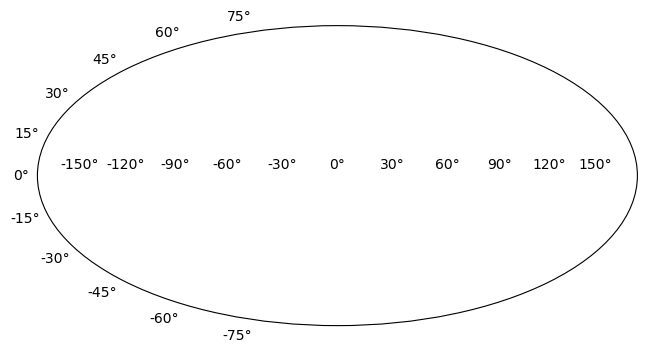

In [14]:
from matplotlib.pyplot import figure

fig = figure(figsize=(6,3));
fig.add_axes((0,0,1,1),projection='hammer');

### Substrato composto

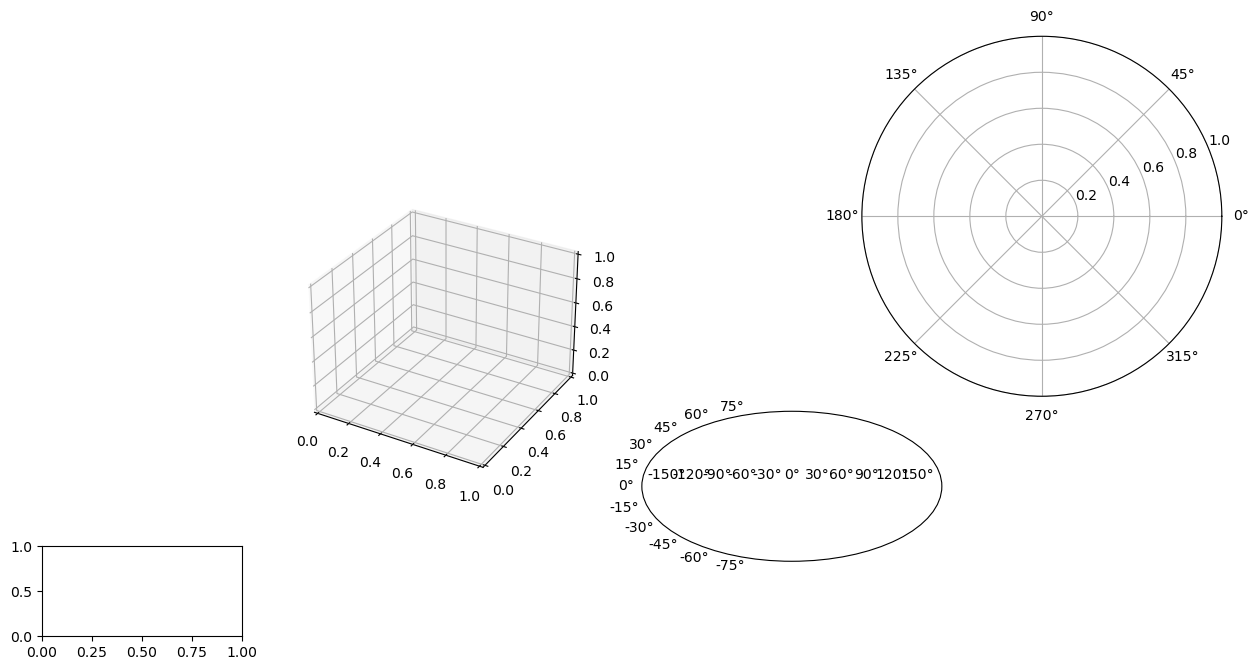

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,3))

# (left,bottom,width,height)
fig.add_axes((0,0,0.4,0.3),projection='rectilinear')
fig.add_axes((0.5,0.5,0.6,1.0),projection='3d')
fig.add_axes((1,0.25,1.0,0.5),projection='aitoff')
fig.add_axes((1.5,0.8,1.0,1.2),projection='polar');


### Categorias e tipos de dados

- Vale acomodar o espectro das definições para considerar duas categorias principais e algumas subcategorias da seguinte forma:

- **Dado quantitativo**
    - _Numérico contínuo_: valores numéricos (inteiros, racionais, reais);
    - _Numérico discreto_: comumemente inteiros, mas podem ser fracionários quando não há valores intervalares a considerar;
    

- **Dado qualitativo**
    - _Categórico não ordenado_: discretos e sem ordem natural. Também chamado de _fatores_.
    - _Categório ordenado_ (ordinal): discretos e ordenados. Também chamado de _fatores ordenados_.

_Data_, _hora_ e _texto_ são casos especiais que não categorizaremos por, às vezes, se comportarem como quantitativos, qualitativos ou nenhuma das duas categorias.

#### Exemplos 

| Categoria    | Tipo                       | Exemplo                                                     | Descrição                                                                                                                   |
|:-------------|:---------------------------|:------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------|
| Quantitativo | Numérico contínuo          | 2.7,1.22,10,1e-5                                            | Valores numéricos arbitrários.                                                                                              |
| Quantitativo | Numérico discreto          | 1,2,3; 0.5,1.5, 2.5                                         | Números em unidades discretas. Fracionários em escalas especiais.                                                           |
| Qualitativo  | Categórico não ordenado    | mamífero, crustáceo, aracnídeo                              | Categoria únicas, discretas e sem ordem aparente.                                                                           |
| Qualitativo  | Categórico ordenado        | Péssimo, razoável, excelente                                | Categoria únicas, discretas e com ordenamento por significado. “Razoável" é algo entre “péssimo" e “excelente".             |
| -            | Numérico contínuo/Discreto | 23/03/1996, 13:22                                           | Podem ser “contínuos" se considerados em intervalos contíguos (datas sucessivas), ou discretos, se tomados particularmente. |
| -            | -                          | Tempos vividos não retornam; sim/talvez/não; jamais/sempre. | Texto em formato livre não possui categoria definida. Em outras situações, pode ser considerado categórico, discreto.       |


### Atributos e elementos visuais

[Jacques Bertin](https://en.wikipedia.org/wiki/Jacques_Bertin) estabeleceu os fundamentos teóricos para a visualização da informação elencando 7 atributos visuais, ou _canais_

- posição;
- tamanho;
- orientação;
- valor;
- textura (ou granularidade);
- cor; e
- forma.

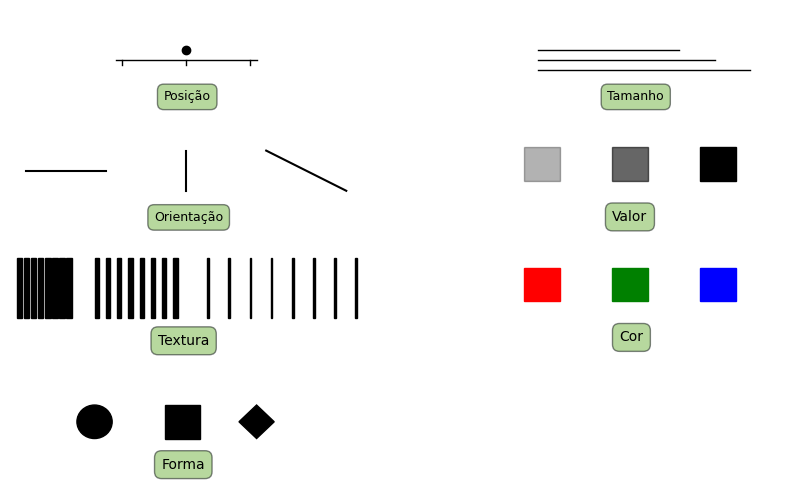

In [17]:
import aux03a2

### Designações para os atributos visuais de Bertin.

| Atributo    | Designações | 
|:-------------|:-----------|
| Posição | esquerda, centro, direita etc. |
| Tamanho | pequeno, médio, grande etc.|
| Orientação | horizontal, vertical, oblíqua |            
| Valor | claro, médio, escuro (tons de cinza) |
| Textura | fina, média, grossa |            
| Cor | vermelho, verde, azul etc. |            
| Forma | círculo, retângulo, polígono de n lados etc. |            

### Elementos visuais possíveis

- ponto;
- linha;
- superfície; e
- volume.

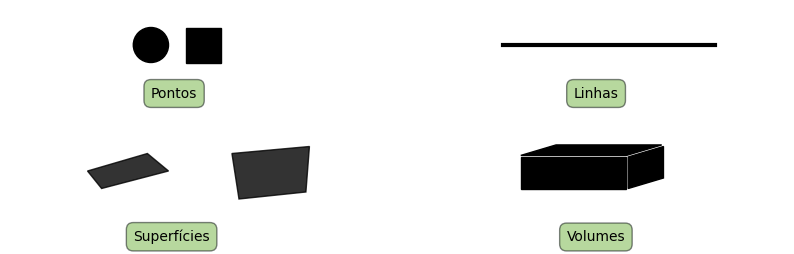

In [18]:
import aux03a3

### Visualização

- Para atingirmos uma visualização eficaz, além de levar em conta todos os aspectos já discutidos na etapa do mapeamento, devemos nos atentar para o bom _design_ e para o propósito da visualização que desenvolveremos.

- Características cruciais a observar em um projeto de visualização são: 
- reproduzir a informação com fidelidade; 
- facilitar a compreensão do espectador; 
- analisar o tipo e a natureza dos dados que serão representados; e
- entender a audiência a quem os dados serão direcionados.

- Elaboração do plano preliminar da RV => maior probabilidade de sucesso do projeto
- O PPRV deve considerar as seguintes variáveis e questões 

1. _Definição do problema_: que representação é necessária? O que desejo comunicar?
2. _Exame da natureza dos dados_: os dados são quantitativos ou qualitativos? Como mapeá-los?

3. _Dimensões_: qual é o número de dimensões dos dados (atributos)? Quais são independentes e quais são dependentes? Os dados são 
- _Univariados_ (uma dimensão varia com respeito a outra)? 
- _Bivariados_ (uma dimensão varia com respeito a outras duas)?
- _Trivariados_ (uma dimensão varia com respeito a outras três)?
- _Multivariados_ (uma dimensão varia com respeito a quatro ou mais dimensões independentes)?

4. _Estrutura de dados_: os dados são 
- _Lineares_ (codificados em vetores, tabelas, matrizes, coleções etc.)? 
- _Temporais_ (mudam com o tempo)? 
- _Geográficos_ ou _espaciais_ (possuem correspondência com algo físico, como mapas, plantas, projeções de terreno etc.)?
- _Hierárquicos_ (sugerem organizações, diretórios, genealogias etc.)? 
- Em forma de _redes_ (descrevem relacionamento entre entidades)?

5. _Tipo de interação_: a visualização é 
- _Estática_ (imagem impressa fisicamente ou em tela de computadores)?
- _Transformável_ (usuário altera parâmetros que modificam e transformam os dados)? 
- _Manipulável_ (usuário tem possibilidade de girar elementos 3D, aplicar _zoom_)?

[Fonte](https://adenilsongiovanini.com.br/blog/semiologia-grafica-aplicada-e-cartografia-tematica/)

#### Etapas do projeto preliminar de visualização de dados

| Problema | Tipo de dado | Dimensões | Estrutura de dados |  Tipo de interação |
|:-------------|:-----------|:-----------|:-----------|:-----------|
|comunicar<br>explorar<br>confirmar|quantitativo<br>qualitativo|univariado<br>bivariado<br>trivariado<br>multivariado|linear<br>temporal<br>espacial<br>hierárquico<br>rede|estático<br>transformável<br>manipulável| 


#### Exemplo 1: visualizando o número de cirurgias e partos por bloco

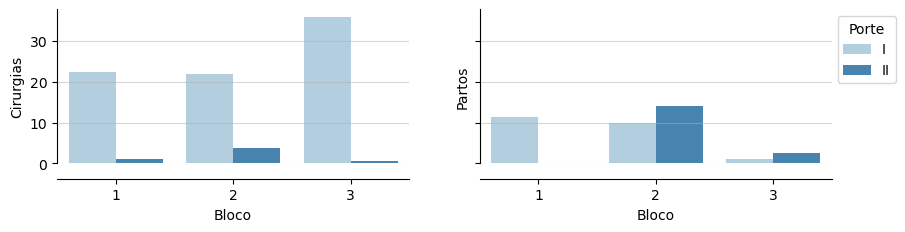

In [20]:
import seaborn as sns

# reindexação
df_h2 = df_h.reset_index()

# conversão do tipo de dados
df_h2['Cirurgias'] = df_h2['Cirurgias'].astype(int)
df_h2['Partos'] = df_h2['Partos'].astype(int)

# plotagem principal
fig, ax = plt.subplots(1,2,figsize=(10,2),sharey=True)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
p1 = sns.barplot(x='Bloco',y='Cirurgias',hue='Porte',data=df_h2,errorbar=None,palette='Blues',ax=ax[0])
p2 = sns.barplot(x='Bloco',y='Partos',hue='Porte',data=df_h2,errorbar=None,palette='Blues',ax=ax[1])

# eixos
p1.spines['top'].set_visible(False)
p1.spines['right'].set_visible(False)
p1.spines['bottom'].set_position(('axes', -0.1))

p2.spines['top'].set_visible(False)
p2.spines['right'].set_visible(False)
p2.spines['bottom'].set_position(('axes', -0.1))

# legenda
p1.get_legend().remove()
p2.legend(title='Porte',bbox_to_anchor=(1.2,1.0));

#### Exemplo 2: plotando série temporal de temperatura

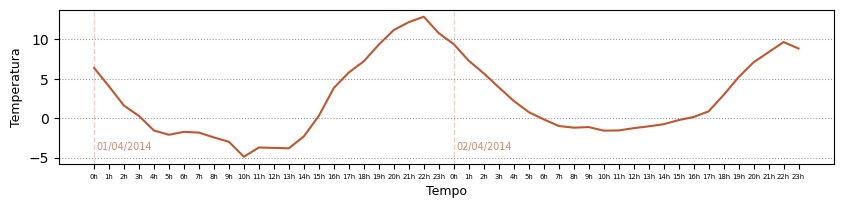

In [21]:
import numpy as np

df_hours = df_t['date'][0::60].index
df_ti = df_t.iloc[df_hours][:48]

fig, ax = plt.subplots(figsize=(10,2))
ax.plot(df_ti['mean'],c='#be5631',lw=1.5)

da = np.array(list((df_ti['mean'].index)))
db = np.array(2*[str(i) + 'h' for i in range(0,24)])
ax.set_xticks(da,db,fontsize=5)

half = int(len(da)/2)

ax.axvline(0,ls='--',lw=1,c='#d1886e',alpha=0.4)
ax.axvline(da[half],ls='--',lw=1,c='#d1886e',alpha=0.4)
ax.grid(axis='y',ls=':',c='k',alpha=0.4)

ax.set_xlabel('Tempo',fontsize=9)
ax.set_ylabel('Temperatura',fontsize=9)

ax.text(10,-4,s='01/04/2014',fontsize=7,c='#d1886e')
ax.text(1450,-4,s='02/04/2014',fontsize=7,c='#d1886e');